# Create a Hillshade from a Terrain Raster in Python 

In this tutorial, we will learn how to create a hillshade from a terrain raster in Python. 

First, let's import the required packages and set plot display to inline:

In [1]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

We also need to import the following fuctions created in previous lessons:
- ```raster2array.py```
- ```plotbandarray.py```

In [2]:
# %load ../neon_aop_python_functions/raster2array.py

# raster2array.py reads in the first band of geotif file and returns an array and associated 
# metadata dictionary.
# Input: raster_geotif (eg. 'raster.tif')
# Outputs:
# array_rows: # of rows in the array
# array_cols: # of columns in the array
# bands: # of bands 
# driver: (for NEON data this is Geotif)
# projection: 
# geotransform: 
# pixelWidth: width of pixel (for NEON data this = 1)
# pixelHeight: height of pixel (for NEON data this = -1)
# ext_dict: dictionary of raster extent, containing the following information 
#           {'xMin': xMin_value,'xMax': xMax_value, 'yMin': yMin_value, 'yMax': yMax_value}
#           Note: to extract a value from ext_dict, use the syntax: eg. xMin = metadata['ext_dict']['xMin']
# extent: raster extent values (xMin, xMax, yMin, yMax)
# noDataValue: no data value 
# scaleFactor: scale factor 
# band_stats: dictionary of statistics for band 1:
#           {'min': min_value, 'max': max_value, 'mean': mean_value, 'stdev': stdev_value}
#           Note: to extract a value from band_stats dictionary, use the syntax: 
#                 eg. array_min = metadata['band_stats']['min']

# Usage: array, metadata = raster2array('raster.tif')

from osgeo import gdal
import numpy as np

def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]
#     metadata['xMin'] = mapinfo[0]
#     metadata['yMax'] = mapinfo[3]
#     metadata['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
#     metadata['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]
    
    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
        
        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)
        
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==int(metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
        return array, metadata
    
    elif metadata['bands'] > 1:
        print('More than one band ... fix function for case of multiple bands')

In [3]:
# %load ../neon_aop_python_functions/plot_band_array.py

def plot_band_array(band_array,refl_extent,title,cbar_label,colormap='spectral',alpha=1):
    plt.imshow(band_array,extent=refl_extent,alpha=alpha); 
    cbar = plt.colorbar(); plt.set_cmap(colormap); 
    cbar.set_label(cbar_label,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

###  Calculate Hillshade

<img src="http://www.geography.hunter.cuny.edu/~jochen/GTECH361/lectures/lecture11/concepts/Hillshade_files/image001.gif" style="width: 250px;"/>
<center><font size="2">http://www.geography.hunter.cuny.edu/~jochen/GTECH361/lectures/lecture11/concepts/Hillshade.htm</font></center>


Hillshade is used to visualize the hypothetical illumination value (from 0-255) of each pixel on a surface given a specified light source. To calculate hillshade, we need the zenith (altitude) and azimuth of the illumination source, as well as the slope and aspect of the terrain. The formula for hillshade is:

$$Hillshade = 255.0 * (( cos(zenith_I)*cos(slope_T))+(sin(zenith_I)*sin(slope_T)*cos(azimuth_I-aspect_T))$$

Where all angles are in radians. 

For more information about how hillshades work, refer to the ESRI ArcGIS Help page: http://webhelp.esri.com/arcgisdesktop/9.2/index.cfm?TopicName=How%20Hillshade%20works. 

In [4]:
#https://github.com/rveciana/introduccion-python-geoespacial/blob/master/hillshade.py

def hillshade(array,azimuth,angle_altitude):
    azimuth = 360.0 - azimuth 
    
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.
 
    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)
    
    return 255*(shaded + 1)/2

Now that we have a function to generate hillshade, we need to read in the NEON LiDAR Digital Terrain Model (DTM) geotif using the ```raster2array``` function and then calculate hillshade using the ```hillshade``` function. We can then plot both using the ```plot_band_array``` function. 

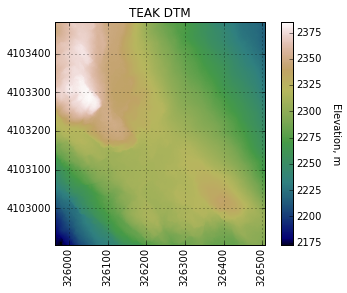

In [5]:
# Use raster2array to convert TEAK DTM Geotif to array & plot
dtm_array, dtm_metadata = raster2array('TEAK_D17_Data_2013/TEAK_LiDAR_Data/TEAK_lidarDTM.tif')
plot_band_array(dtm_array,dtm_metadata['extent'],'TEAK DTM','Elevation, m',colormap='gist_earth')
ax = plt.gca(); plt.grid('on')

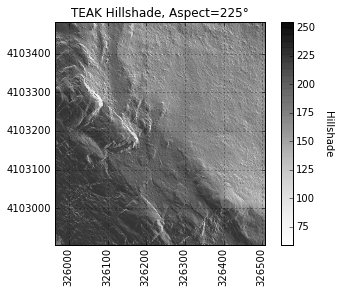

In [6]:
# Use hillshade function on a DTM Geotiff
hs_array = hillshade(dtm_array,225,45)
plot_band_array(hs_array,dtm_metadata['extent'],'TEAK Hillshade, Aspect=225°',
                'Hillshade',colormap='Greys',alpha=0.8)
ax = plt.gca(); plt.grid('on') 

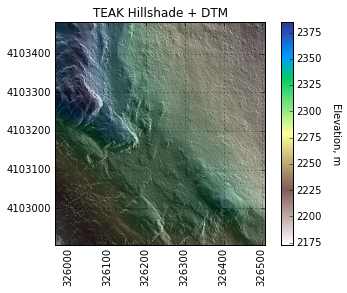

In [7]:
#Overlay transparent hillshade on DTM:
fig = plt.figure(frameon=False)
im1 = plt.imshow(dtm_array,cmap='terrain_r',extent=dtm_metadata['extent']); 
cbar = plt.colorbar(); cbar.set_label('Elevation, m',rotation=270,labelpad=20)
im2 = plt.imshow(hs_array,cmap='Greys',alpha=0.8,extent=dtm_metadata['extent']); #plt.colorbar()
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
plt.grid('on'); # plt.colorbar(); 
plt.title('TEAK Hillshade + DTM')

### Calculate CHM & Overlay on Top of Hillshade

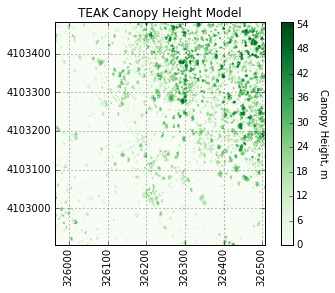

In [8]:
#Calculate CHM from DSM & DTM:
dsm_array, dsm_metadata = raster2array('TEAK_D17_Data_2013/TEAK_LiDAR_Data/TEAK_lidarDSM.tif')
teak_chm = dsm_array - dtm_array;

plot_band_array(teak_chm,dtm_metadata['extent'],'TEAK Canopy Height Model','Canopy Height, m',colormap='Greens')
ax = plt.gca(); plt.grid('on')

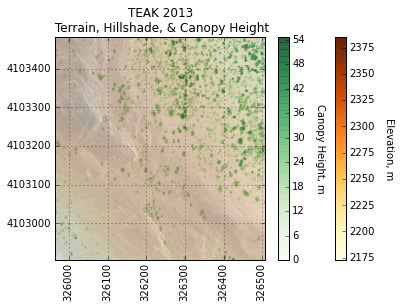

In [9]:
#Overlay transparent hillshade on DTM:
fig = plt.figure(frameon=False)

#Terrain
im1 = plt.imshow(dtm_array,cmap='YlOrBr',extent=dtm_metadata['extent']); 
cbar1 = plt.colorbar(); cbar1.set_label('Elevation, m',rotation=270,labelpad=20)

#Hillshade
im2 = plt.imshow(hs_array,cmap='Greys',alpha=.5,extent=dtm_metadata['extent']); #plt.colorbar()

#Canopy
im3 = plt.imshow(teak_chm,cmap='Greens',alpha=0.6,extent=dtm_metadata['extent']); 
cbar2 = plt.colorbar(); cbar2.set_label('Canopy Height, m',rotation=270,labelpad=20)

ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
plt.grid('on'); # plt.colorbar(); 
plt.title('TEAK 2013 \n Terrain, Hillshade, & Canopy Height')

## Links to Tutorials on Creating Hillshades:

**Python Hillshade:**
- http://geoexamples.blogspot.com/2014/03/shaded-relief-images-using-gdal-python.html
- http://pangea.stanford.edu/~samuelj/musings/dems-in-python-pt-3-slope-and-hillshades-.html

**ESRI ArcGIS Hillshade Algorithm:**
- http://webhelp.esri.com/arcgisdesktop/9.2/index.cfm?TopicName=How%20Hillshade%20works

**GitHub Hillshade Functions/Tutorials:**
- https://github.com/rveciana/introduccion-python-geoespacial/blob/master/hillshade.py
- https://github.com/clhenrick/gdal_hillshade_tutorial

**GDAL Hillshade:**
- http://www.gdal.org/gdaldem.html
- http://gis.stackexchange.com/questions/144535/how-to-create-transparent-hillshade/144700

## Scratch Code

In [ ]:
#Importing the TEAK CHM Geotiff resulted in v. sparse data ?
chm_array, chm_metadata = raster2array('TEAK_lidarCHM.tif')

print('TEAK CHM Array\n:',chm_array)
# print(chm_metadata)

#print metadata in alphabetical order
for item in sorted(chm_metadata):
    print(item + ':', chm_metadata[item])
    
# print(chm_metadata['extent'])

import copy
chm_nonzero_array = copy.copy(chm_array)
chm_nonzero_array[chm_array==0]=np.nan
print('TEAK CHM nonzero array:\n',chm_nonzero_array)
print(np.nanmin(chm_nonzero_array))
print(np.nanmax(chm_nonzero_array))